In [2]:
import numpy as np

T, H = 5,4
hs = np.random.randn(T,H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5,1).repeat(4, axis=1)
print(ar)
print(ar.shape)

t = hs * ar

print(t)

print(t.shape)

c = np.sum(t,axis=0)

print(c.shape)


[[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.03 0.03 0.03 0.03]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]]
(5, 4)
[[ 0.87955006 -0.28032269 -0.87551197 -0.0637079 ]
 [ 0.03399225 -0.07417707 -0.05522188 -0.01748107]
 [ 0.01536236  0.04972418  0.05218047  0.00361532]
 [-0.07426286  0.00515815  0.10051989 -0.1137662 ]
 [-0.02346407  0.02263561  0.00564242 -0.02606067]]
(5, 4)
(4,)


In [ ]:
class AttentionWeight:
    def __init__(self):
        self.params = []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N,T,H = hs.shape

        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh
    

In [ ]:
from attention_layer import WeightSum

class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [6]:
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import Attention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        self.embed.backward(dout)
        return dout

In [13]:
#from ch07.peeky_seq2seq import PeekySeq2seq

from ch07.seq2seq import *

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 2[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 4[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 7[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 9[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 12[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 14[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 17[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 19[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 22[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 23[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 26[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 28[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 30[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 32[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 34[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 36[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 38[s] | loss 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11

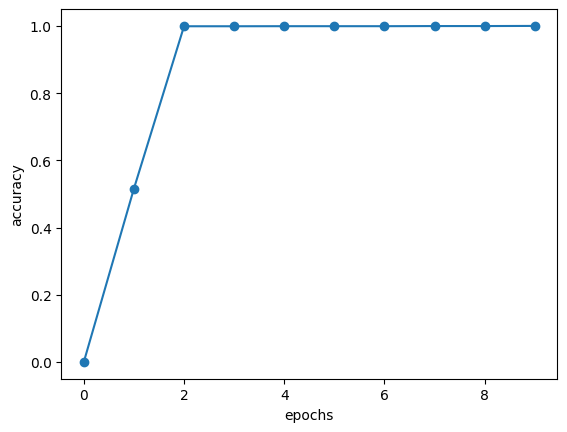

In [17]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
import ch07.seq2seq
from ch07 import *
#from ch07.peeky_seq2seq import PeekySeq2seq


# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))


model.save_params()

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()


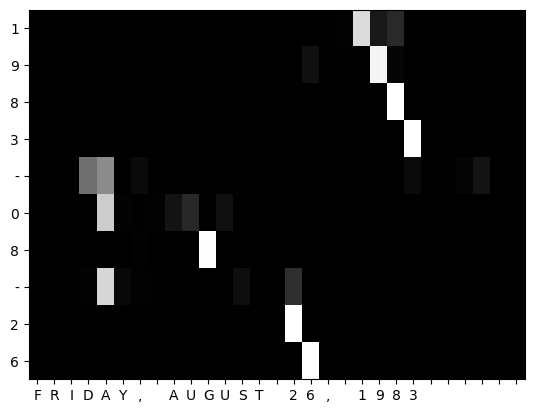

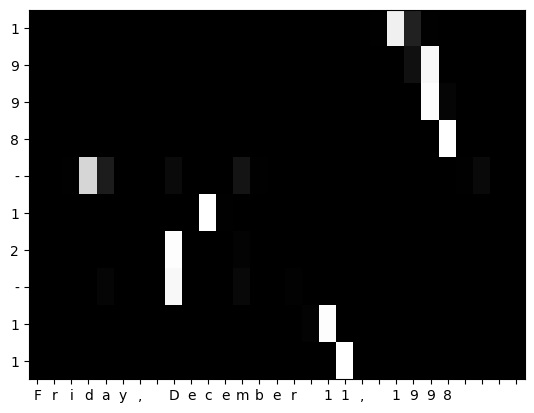

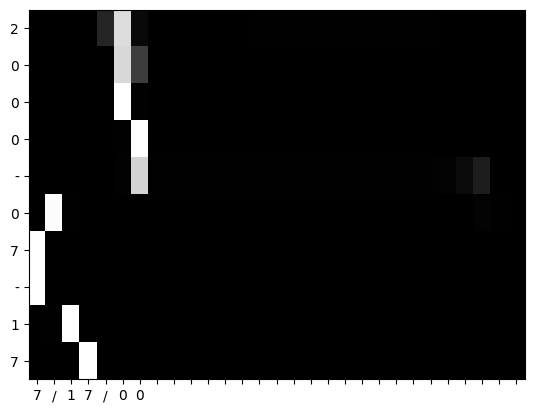

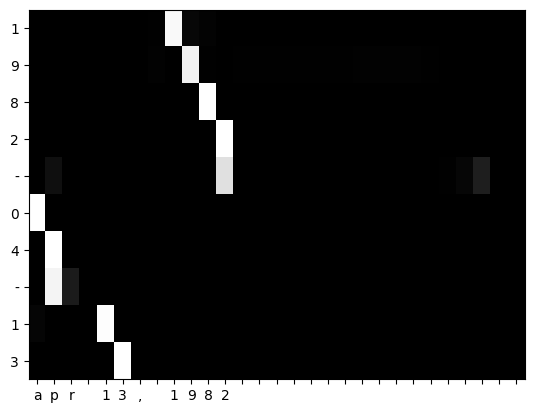

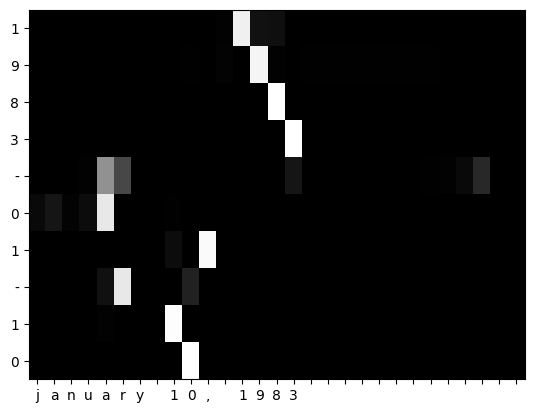

TypeError: 'module' object is not callable

In [20]:
import visualize_attention

visualize_attention()